In [1]:
import os, sys

import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import savgol_filter

from matplotlib import pyplot as plt
import src.plotter as plotter

import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog
from tkinter import ttk

import warnings
warnings.filterwarnings('ignore')

plotter.initialize(plt)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

In [2]:
tk.Tk().withdraw() # prevents an empty tkinter window from appearing
root_folder = 'BCS 915_172.16.148.45/Process-Export' # general registery to access the data

Data_path = Path(filedialog.askdirectory(initialdir = root_folder)) # select in the window the folder to open (folder format: YYYYMMDD_TEV1_Ref-Cells_CLT)

print(Data_path) # show the path selected

output_path = Path(os.path.join(Data_path, 'Graphs_Output')) # synch to choosen Data_path the subfolder 'Graphs_Output' to save the results

C:\Users\mmeyer\OneDrive - FIB Srl\Documents\Python\TEV1_Cell Testing\BCS 915_172.16.148.45\Process-Export\20250121_TEV1_STD_CLT


In [ ]:
#Creation of the dictionaries for charge and discharge steps
Ch_C_rate_dict = {'1C': ['CC_CV'],
                  'C10': ['CC_CV']
                  }

Dch_C_rate_dict = {'1C': ['CC'],
                   'C10': ['CC']
                   }

root = tk.Tk() 
root.withdraw()  # prevents an empty tkinter window from appearing 

# List of C-rates to call the dictionaries
options = ["1C", "C10"]

# Open a dialog window to select a value from options list
C_rate_key = simpledialog.askstring("Select a C-rate", 
                                              "Choose a C-rate:\n" + "\n".join(options)).strip()

# Show the path that will be opened depending on the C_rate selected
if C_rate_key == '1C':
    Final_Path = Path(os.path.join(Data_path, '1C_rate_Cycles'))

elif C_rate_key == 'C10':
    Final_Path = Path(os.path.join(Data_path, 'C10_rate_Cycles'))

# Check if a C_rate has been selected
if C_rate_key in options:
    print(f"You have selected: {C_rate_key}")
else:
    print("Non-valid input or withdrawal")
    exit()

    # Create variable used for filtering 
Charge_Step = Ch_C_rate_dict.get(C_rate_key, None)
Discharge_Step = Dch_C_rate_dict.get(C_rate_key, None)

print(Final_Path)

You have selected: C10
C:\Users\mmeyer\OneDrive - FIB Srl\Documents\Python\TEV1_Cell Testing\BCS 915_172.16.148.45\Process-Export\20250121_TEV1_STD_CLT\C10_rate_Cycles


In [4]:
# Create the list that will contain the test files
file_list = [file for file in Final_Path.iterdir() if file.is_file()]

# Show the files that will be processed
for file in file_list:
    print(Path(file).stem)

C10_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_A.1
C10_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_A.5
C10_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_B.1
C10_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_B.5
C10_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_C.1
C10_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_C.5
C10_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_D.1
C10_2025-02-10_14-52-45_TEV1 Cells_20250121_TEV1_STD_CLT_D.5


In [5]:
# Define the columns to use for DVA processing - Used to define the columns to load in Data Frame for the analysis
columns = ['Step', 'Task', 'Cycle number', 'U /V', 'I /A', 'Q charge /Ah', 'Q discharge /Ah', 'Capacity /Ah']

Charge_Step = Ch_C_rate_dict.get(C_rate_key, None)
Discharge_Step = Dch_C_rate_dict.get(C_rate_key, None)

In [6]:
# Create a C_rate dictionary
c_rate_dict = {'1C': 1,
               'C10': 0.1
               }

In [7]:
df_list = []

# Create the data frame for each test file, can recognise the type of cycle to process based on the C-rate
for file in file_list:
    df = pd.read_csv(file, usecols = columns)
    curr_c_rate_str = file.name.split('_')[0]    

    if curr_c_rate_str in c_rate_dict:
        if curr_c_rate_str == '1C':
            df_list.append(df)
                
        elif curr_c_rate_str == 'C10':
            df_list.append(df)

In [ ]:
# dV/dQ - works for multiple cycles

def process_data_set(file_list, C_rate_key, operation = 'charge', is_normalized = False):
    
    Charge_Step = Ch_C_rate_dict.get(C_rate_key, None)
    Discharge_Step = Dch_C_rate_dict.get(C_rate_key, None)

    c_rate_array = np.array([c_rate_dict[C_rate_key]] * len(df_list)) if df_list else np.array([])

        # Define a list of color to use for each plot based on the number of files to process
    color = plt.cm.rainbow(np.linspace(0, 1, len(df_list)))
    fh = plt.figure(figsize=(8, 10))

    # Define plots format
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)

    chg_cap_array = []
    dch_cap_array = []

    offs = 0

        # Process the data frame on by one for the analysis
    for df, file, col, c_rate in zip(df_list, file_list, color, list(c_rate_array)):

        #print(f"Processed file: {Path(file).stem}")
            # Filter the data frame df in two data frame for charges and discharges
        if Charge_Step is not None:
            df_CH = df[df['Task'].isin(Charge_Step)]
        else:
            df_CH = pd.DataFrame()

        if Discharge_Step is not None:
            df_DCH = df[df['Task'].isin(Discharge_Step)]
        else:
            df_DCH = pd.DataFrame()

        if df_CH.empty or df_DCH.empty:
            continue  # Go to next file if no result is found

            # Calculate the maximum capacity in charge and discharge for each file
        Qmax = np.max(df_DCH['Q discharge /Ah'])
        Qmax_ch = np.max(df_CH['Q charge /Ah'])
        #print(Qmax)

            # Create a new data frame to remove the CV step in charges
        
        # Filter the data by cycle count
        for cycle in df_CH['Cycle number'].unique():
            df_CH_cycle = df_CH[df_CH['Cycle number'] == cycle]

            filter_df_CH = df_CH_cycle[df_CH_cycle['I /A'].between(4.5, 5.5)]
            #x axis values definition
            x_ch = filter_df_CH['Q charge /Ah'].dropna()
            x_ch = x_ch / np.max(x_ch) if is_normalized else x_ch

            #y axis values definition
            y_ch = filter_df_CH['U /V'].loc[x_ch.index]

            # Definition of the parameters to run the Savitzky-Golay filter
            size_factor = 70
            window_length = int(len(x_ch) / size_factor)
            window_length = window_length + 1 if window_length % 2 == 0 else window_length
            polyorder = 2

            # Smoothen the data for each axis using the Savitzky-Golay filter
            dQch = savgol_filter(x_ch, window_length, polyorder, 1)
            dVch = savgol_filter(y_ch, window_length, polyorder, 1)
            
            # Create the graphs and plot the data separately for charges
            if operation == 'charge':
                ax1.plot(x_ch, y_ch, color = col, label=f'Channel:{(os.path.splitext(os.path.basename(file))[0]).split('_')[8]}, Cycle:{cycle}, {c_rate: .2f}C, {np.max(x_ch): .3f}Ah')
                ax2.plot(x_ch, np.abs(dVch/dQch)*Qmax, c=col)

                #print(f'{Path(file).stem}\n{Qmax_ch} Ah\n{operation}\n')

        # Filter the data by cycle count
        for cycle in df_DCH['Cycle number'].unique():
            df_DCH_cycle = df_DCH[df_DCH['Cycle number'] == cycle]
            #x axis values definition
            x_dch = df_DCH_cycle['Q discharge /Ah'].dropna()
            x_dch = x_dch / np.max(x_dch) if is_normalized else x_dch
            
            #y axis values definition
            y_dch = df_DCH_cycle['U /V'].loc[x_dch.index]

            # Definition of the parameters to run the Savitzky-Golay filter
            size_factor = 70
            window_length = int(len(x_dch) / size_factor)
            window_length = window_length + 1 if window_length % 2 == 0 else window_length
            polyorder = 2

            # Smoothen the data for each axis using the Savitzky-Golay filter
            dQdch = savgol_filter(x_dch, window_length, polyorder, 1)
            dVdch = savgol_filter(y_dch, window_length, polyorder, 1)
            
            # Create the graphs and plot the data separately for discharges
            if operation == 'discharge':
                ax1.plot(x_dch, y_dch, color = col, label=f'Channel:{(os.path.splitext(os.path.basename(file))[0]).split('_')[8]}, Cycle:{cycle}, {c_rate: .2f}C, {np.max(x_dch): .3f}Ah')
                ax2.plot(x_dch, np.abs(dVdch/dQdch)*Qmax, c=col)

                #print(f'{Path(file).stem}\n{Qmax} Ah\n{operation}\n')
        
        chg_cap_array.append(np.max(x_ch))
        dch_cap_array.append(np.max(x_dch))

        # Define the parameters for visual layout of the graphs
    ax2.set_ylim(0, 3.0)
    xlabel = 'Capacity /Ah'
    ax2.set_xlabel(xlabel)
    ax1.legend(fontsize=11.5)
    ax1.grid(False)
    ax2.grid(False)
    ax1.set_ylabel('U /V')
    ax2.set_ylabel('dV/dQ')

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.sans-serif"] = ["DejaVu Sans"]
    plt.tight_layout()
    plt.savefig(f'{output_path}/fig_dvdq_details_full_cell_{C_rate_key}_{operation}.png', dpi=300)

    res = dict()
    res['chg_cap_array'] = chg_cap_array
    res['dch_cap_array'] = dch_cap_array
    res['c_rate_array'] = c_rate_array

    return res

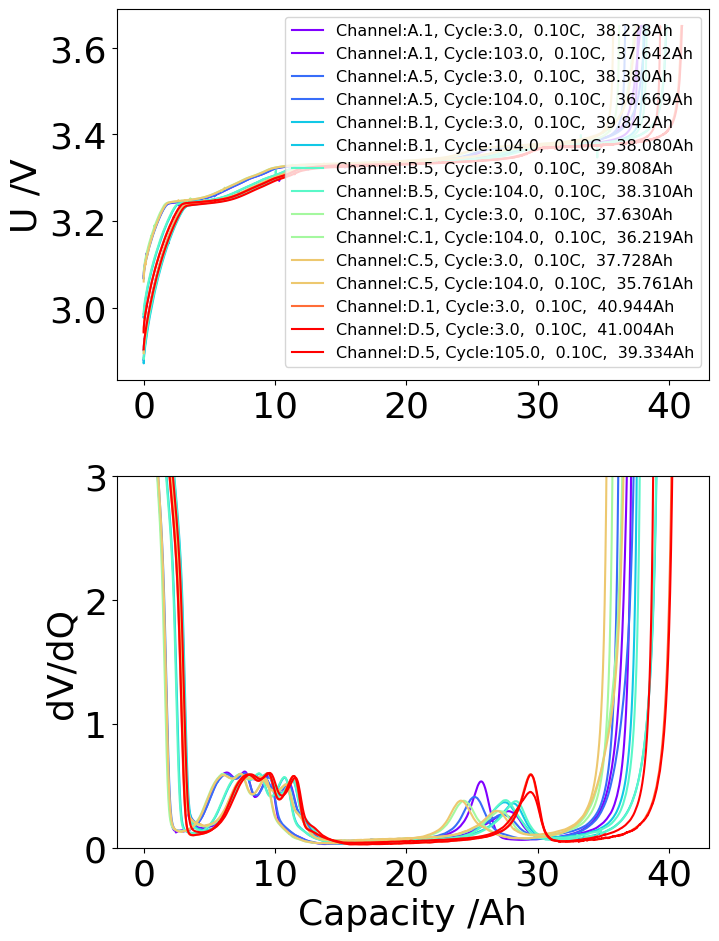

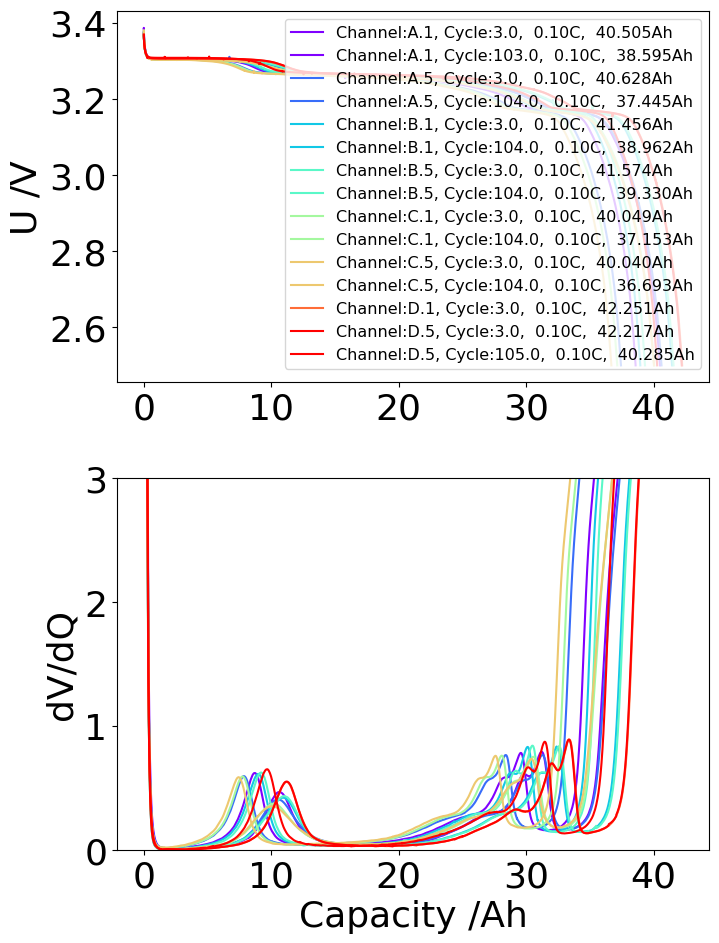

In [9]:
    # Generate the graphs
res_charge = process_data_set(file_list, C_rate_key, operation='charge', is_normalized=False)
res_discharge = process_data_set(file_list, C_rate_key, operation='discharge', is_normalized=False)